In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from transmon_code.helpers import *
from qutip import *
from scipy.optimize import fsolve
from copy import deepcopy
from scipy.interpolate import CubicHermiteSpline
from scipy.fft import rfft, rfftfreq, fftshift

In [2]:
# set up H0 and H1

# number of dimensions
n_levels = 8
# these are in rads per second e6
Ω_desired = 2*np.pi*3981
α_desired = 2*np.pi*-199

# funcs
a = destroy(n_levels)
e_ops = [basis(n_levels, i) * basis(n_levels, i).dag() for i in range(n_levels)]

# optimises the input freqs to get them represented accurately in the Hamiltonian
def make_H0(Ω,α):
    Ec = -α
    Ej = (Ω + Ec)**2 / (2*Ec)

    nhat = 1j * (Ej/(32*Ec))**0.25 * (a.dag()-a)
    φhat = (2*Ec/Ej)**0.25 * (a.dag()+a)

    H0 = 4*Ec*nhat**2 - Ej*φhat.cosm()
    return H0

def find_true_freqs(Ω_in, α_in):
    H0 = make_H0(Ω_in, α_in)
    eigs = H0.eigenenergies()
    Ω_true = np.real(eigs[1]-eigs[0])
    α_true = np.real((eigs[2]-eigs[1])-(eigs[1]-eigs[0]))
    return np.array([Ω_true,α_true])

def optimise_Ω(Ω_in,α_in):
    if isinstance(Ω_in, np.int32) or isinstance(Ω_in, np.float64):
        Ω2, _ = find_true_freqs(Ω_in,α_in)
        return Ω2 - Ω_desired
    else:
        return [optimise_Ω(i,α_in) for i in Ω_in]
    
def optimise_α(α_in,Ω_in):
    if isinstance(α_in, np.int32) or isinstance(α_in, np.float64):
        _, α2 = find_true_freqs(Ω_in,α_in)
        return α2 - α_desired
    else:
        return [optimise_α(i,Ω_in) for i in α_in]

Ω = fsolve(optimise_Ω, Ω_desired, α_desired)[0]
α = fsolve(optimise_α, α_desired, Ω)[0]
for i in range(10):
    Ω = fsolve(optimise_Ω, Ω, α)[0]
    α = fsolve(optimise_α, α, Ω)[0]

H0 = make_H0(Ω,α)
print(find_true_freqs(Ω,α)/2/np.pi)
print((Ω-α)**2/(2*α**2))

# H0 = Ω_desired*a.dag()*a + 0.5*α_desired*a.dag()*a*(a.dag()*a-1)

# check the form of this Hamiltonian!
H1 = a + a.dag()

[3981. -199.]
68.03726191008971


In [3]:
# envelope shapes

A,x,τ,Γ = sym.symbols("A,x,τ,Γ")

Γ = τ/4

Ωg = A * (sym.pi/2) * (sym.exp((-1*(x-τ/2)**2)/(2*Γ**2))-sym.exp((-1*τ**2)/(8*Γ**2))) / (sym.sqrt(2*sym.pi*Γ**2)*sym.erf(τ/(sym.sqrt(8)*Γ))-τ*sym.exp((-1*τ**2)/(8*Γ**2)))

Ωgprime = sym.diff(Ωg,x)

padding = 0.002
Γ = τ-2*padding

Ωb = A * (50*sym.pi/(42*Γ)) * (0.42 - 0.5*sym.cos(2*sym.pi*(x-padding)/Γ) + 0.08*sym.cos(4*sym.pi*(x-padding)/Γ))

Ωb = sym.Piecewise(
    (0,x<padding),
    (0,x>τ-padding),
    (Ωb, True))

Ωbprime = sym.diff(Ωb,x)

Ω = sym.lambdify([x,A,τ], Ωb, modules=['numpy', 'math'])
Ωprime = sym.lambdify([x,A,τ], Ωbprime, modules=['numpy', 'math'])

In [4]:
# H1 coeffs

def H1_coeffs(t,args):
    # args["2nd order"] is 1 if true and 0 if false

    A,τ,λ,α,ω = args["A"], args["τ"], args["λ"], args["α"], args["ω"]

    match args["type"]:
        case 1:
            Ωx = Ω(t,A,τ) + args["2nd order"] * λ**2 * Ω(t,A,τ)**3 / (8*α**2)
            Ωy = 0
            δ = λ**2 * Ω(t,A,τ)**2 / (4*α)
        case 2:
            Ωx = Ω(t,A,τ) - args["2nd order"] * λ**2*(λ**2-4)*Ω(t,A,τ)**3/(32*α**2)
            Ωy = -λ**2 * Ωprime(t,A,τ) / (4*α)
            δ = 0
        case 3:
            Ωx = Ω(t,A,τ)
            Ωy = -λ * Ωprime(t,A,τ) / (2*α)
            δ = (λ**2-2*λ) * Ω(t,A,τ)**2 / (4*α)
        case 4:
            Ωx = Ω(t,A,τ) + args["2nd order"] * (λ**2-4)*Ω(t,A,τ)**3/(8*α**2)
            Ωy = -Ωprime(t,A,τ) / α
            δ = (λ**2-4) * Ω(t,A,τ)**2 / (4*α)

    return Ωx*np.cos((ω+δ)*t) + 1j*Ωy*np.sin((ω+δ)*t)

def H1_coeffs(t,args):

    A,τ,λ,α,ω = args["A"], args["τ"], args["λ"], args["α"], args["ω"]

    Ωx = Ω(t,A,τ)
    Ωy = -λ*Ωprime(t,A,τ)/α

    return (Ωx*np.cos(ω*t)) + (Ωy*np.sin(ω*t))

def H1_coeffs(t,args):

    A,τ,λ,α,ω = args["A"], args["τ"], args["λ"], args["α"], args["ω"]

    offset = args.get("offset", 0)
    φ = args.get("φ", 0)

    Ωx = Ω(t-offset,A,τ)
    Ωy = -λ*Ωprime(t-offset,A,τ)/α

    return (Ωx*np.cos(ω*t+φ)) + (Ωy*np.sin(ω*t+φ))

In [5]:
def calculate_phi(state1):

    state = deepcopy(state1)

    if state.isket:
        state = ket2dm(state)

    state = truncate(state).unit()

    b = state.full()[1][0]
    return np.arctan2(np.imag(b), np.real(b))

In [6]:
def plot_shape(args):
    t = np.arange(0,args["τ"], 1/100000)
    plt.plot(t, H1_coeffs(t,args))
    plt.show()

In [7]:
def simulate(args, targ=False, plot=False):

    H = [H0, [H1, H1_coeffs]]
    t = np.arange(0,args["τ"], 1/20000)
    ψ0 = basis(n_levels, 0)
    
    res = mesolve(H, ψ0, t, args=args)
    res = [rotate_z(i, Ω_desired*t_i) for i, t_i in zip(res.states, t)]

    ang = -np.pi/2 - calculate_phi(res[-1])
    res = [rotate_z(i, ang) for i in res]

    if plot:
        plot_bloch(res[::20]+[res[-1]])

    if targ:
        targ = (basis(n_levels, 0)-1j*basis(n_levels, 1)).unit()
        return res, fidelity(targ, res[-1])**2
    else:
        return res

In [8]:
def optimise(param, semirange, args):

    tmp_args = deepcopy(args)
    test_values = np.linspace(tmp_args[param]-semirange, tmp_args[param]+semirange, 40)
    fidelities = []

    for i,v in enumerate(test_values):
        print(i, end=" ")
        tmp_args[param] = v
        res = simulate(tmp_args,targ=False,plot=False)

        if param=="A":
            fidelities.append(fidelity(truncate(res[-1]).unit(), (basis(2,0)-1j*basis(2,1)).unit())**2)

        elif param=="λ" or param=="ω" or param == "τ":
            fidelities.append(sum([expect(i,res[-1]) for i in e_ops[:2]]))
            # fidelities.append(fidelity(res[-1], (basis(n_levels,0)-1j*basis(n_levels,1)).unit())**2)

    fidelity_func = CubicHermiteSpline(test_values, fidelities, np.gradient(fidelities, test_values))

    cr_pts = [i for i in fidelity_func.derivative().roots() if i >= test_values[0] and i <= test_values[-1]]

    if len(cr_pts) == 0:
        tmp_args[param] = test_values[np.argmax(fidelities)]
        print("No optimum found for " + param + ", optimal value set to end of test values at " +str(test_values[-1]) + ". Rerun with altered semiranges.")
    else:
        tmp_args[param] = cr_pts[np.argmax(fidelity_func(cr_pts))]

    plt.plot(test_values, fidelities)
    plt.axvline(tmp_args[param], c='r')
    plt.xlabel(param)
    if param == "λ":
        plt.ylabel("1-Leakage")
    else:
        plt.ylabel("Fidelity")
    plt.title("Fidelity variation with " + param)
    plt.show()

    print("Optimal args: "+str(tmp_args))
    return tmp_args

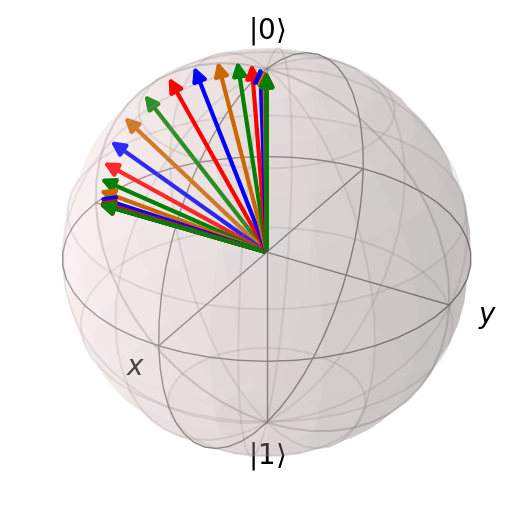

0.9991579043334343
0.000841896919036363
1.987475293156564e-07


In [9]:
%matplotlib qt

# for the first kind of H1_coeffs
args = {"A":1.8, "τ":0.02, "λ":1.5855723966907127, "α":α_desired, "ω":Ω_desired, "type":2, "2nd order":0}

# for a pulse of length 0.05
args = {"A":1.036727745203712, "τ":0.05, "λ":1.3779292385744897, "α":α_desired, "ω":Ω_desired}

# for a pulse of length 0.1
args = {"A":1.1157102379780006, "τ":0.1, "λ":3.08439290279549, "α":α_desired, "ω":Ω_desired}

# for a pulse with an optimised τ
args = {"A":1.013073721398287, "τ":0.06693410345414097, "λ":95.64122236810132, "α":α_desired, "ω":Ω_desired}

args = {"A":1.013073721398287, "τ":0.06693410345414097, "λ":1.396551890770659, "α":α_desired, "ω":Ω_desired}

# for a pulse of length 0.024
args = {"A":1.0250649234185762, "τ":0.024, "λ":-1.4668880681243726, "α":α_desired, "ω":Ω_desired}

plot_shape(args)
res, f = simulate(args, targ=True, plot=True)

levels = [expect(i,res[-1]) for i in e_ops]

print(f)
print(sum(levels[2:]))
print(1-f-sum(levels[2:]))

In [ ]:
plt.bar([i for i in range(len(e_ops))],levels)
plt.yscale("log")
plt.show()

In [ ]:
optimise("λ",0.01,args)